# Modelling PetFinder.my with Logistic Regression

Model: (Multinomial) Logistic Regression.

Evaluation metric: Quadratic Kappa


## Summary of Results

* Best CV Quadratic Weighted Kappa score:
* Best hyper parameters found: [] 
* Commentary on results:
    * Coefficients aren't converging even with max-iteration limit set to 10,000 - indicates that the data may not be suited for logistic regression.
    * Multicollinearity in the data may be a cause of lack of convergence
    * Large C means less regularisation effect - possible indication of overfitting.

## Method

1. Load data
2. Feature engineering
2. Experiment with different hyper parameters using GridSearchCV
3. Train final model on full training set and predict on testing set.

## References

* [Logistic Regression Assumptions](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/assumptions-of-logistic-regression/)
* [Gridsearch (Stackoverflow)](https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv)
* [Baseline Modeling kaggle notebook](https://www.kaggle.com/wrosinski/baselinemodeling)
* [SKLearn metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
* [SKLearn ROC/AUC guide](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)
* [SKLearn Linear Models guide](https://scikit-learn.org/stable/modules/linear_model.html)
* [SKLearn Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import sklearn.linear_model as lm

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import make_scorer
from sklearn.metrics import cohen_kappa_score # https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps

sns.set_style("darkgrid")
sns.set_context("paper")
mpl.style.use("seaborn")

quadratic_kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

In [16]:
SOURCE_DATA_FOLDER = "../data/source/petfinder-adoption-prediction/"
TRAIN_IMAGE_FOLDER = SOURCE_DATA_FOLDER + "train_images/"
TRAIN_METADATA_FOLDER = SOURCE_DATA_FOLDER + "train_metadata/"
TRAIN_SENTIMENT_FOLDER = SOURCE_DATA_FOLDER + "train_sentiment/"

BREED_LABELS = SOURCE_DATA_FOLDER + "breed_labels.csv"
COLOR_LABELS = SOURCE_DATA_FOLDER + "color_labels.csv"
STATE_LABELS = SOURCE_DATA_FOLDER + "state_labels.csv"
TRAIN_TABULAR = SOURCE_DATA_FOLDER + "train/train.csv"
TEST_TABULAR = SOURCE_DATA_FOLDER + "test/test.csv"

quadratic_kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

## 1. Load Data

In [17]:
train_tabular_df = pd.read_csv(TRAIN_TABULAR)
test_tabular_df = pd.read_csv(TEST_TABULAR)

## 1.1 Train a Baseline Model

In [18]:
def splitDataXY(dataset, response_column):
    temp = dataset.copy()
    Y_train = temp[response_column]
    X_train = temp.drop(columns=[response_column])
    return X_train, Y_train

In [20]:
baseline_data = train_tabular_df.drop(columns=['Name', 'RescuerID', 'Description', 'PetID'])
baseline_test = test_tabular_df.drop(columns=['Name', 'RescuerID', 'Description', 'PetID'])

In [21]:
X_baseline, Y_baseline = splitDataXY(baseline_data, 'AdoptionSpeed')

(14993, 19)
(14993,)


In [24]:
def evaluateModel(X, Y, model, verbose=0):
    CV = StratifiedKFold(n_splits=5)
    cv_results = cross_validate(model, X, Y, cv=CV, scoring=quadratic_kappa_scorer, n_jobs=-1, verbose=verbose, return_estimator=True) # n_jobs=-1 means use all cores lol
    return cv_results

In [25]:
baseline_model = lm.LogisticRegression(solver='saga', max_iter=5000)
baseline_cv_results = evaluateModel(X_baseline, Y_baseline, baseline_model, verbose=3)
print("Total fit time:", np.sum(baseline_cv_results['fit_time']))
print("Mean CV Scores (Quadratic Kappa):", np.mean(baseline_cv_results['test_score']))
print("Standard Dev of CV Scores:", np.std(baseline_cv_results['test_score']))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   53.0s remaining:  1.3min


Total fit time: 265.52639722824097
Mean CV Scores (Quadratic Kappa): 0.1619661198586066
Standard Dev of CV Scores: 0.010875341609582563


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.9s finished


Our baseline prediction has a Quadratic Weighted Kappa of **0.2130 (4dp.)**. This is the evaluation to beat.

---

## 2. Preprocess data and transform features

In [24]:
def getRescuerIDCountMap(data):
    rescuerid_counts = data['RescuerID'].value_counts().to_dict()
    return rescuerid_counts

def encodeRescuerIDCount(data, mapping):
    dataset = data.copy()
    dataset['RescuerID_Count'] = dataset['RescuerID'].map(mapping).fillna(0)
    return dataset

def createRescuerIDCount(data):
    # RescuerID Counts
    dataset = data.copy()
    rescuerid_counts = getRescuerIDCountMap(dataset)
    dataset = encodeRescuerIDCount(dataset, rescuerid_counts)
    return dataset, rescuerid_counts

def createDummyVariables(data):
    dataset = data.copy()
    # fee 0 dummy
    dataset['Flag_Fee_0'] = np.nan
    dataset['Flag_Fee_0'] = dataset['Flag_Fee_0'].mask(dataset['Fee'] == 0, 1)
    dataset['Flag_Fee_0'] = dataset['Flag_Fee_0'].fillna(0)

    # breed dummy variables
    mixed_breed_id = 307

    # pure breeds are where Breed1 == Breed2
    pure_breed_cond = (dataset['Breed1'] != mixed_breed_id) & (dataset['Breed1'] == dataset['Breed2'])
    dataset['Flag_Pure_Breed'] = np.nan
    dataset['Flag_Pure_Breed'] = dataset['Flag_Pure_Breed'].mask(pure_breed_cond, 1)
    dataset['Flag_Pure_Breed'] = dataset['Flag_Pure_Breed'].fillna(0)

    # we define mixed breeds as Breed1 or Breed2 being Mixed-Breed, or Breed1 != Breed2 where Breed1 and Breed2 are not Mixed-Breed
    mixed_breed_cond = ((dataset['Breed1'] == 307) | (dataset['Breed2'] == 307)) | ((dataset['Breed1'] != dataset['Breed2']) & 
                                                                                             (dataset['Breed2'] != 0) & 
                                                                                             (dataset['Breed2'] != 307)& 
                                                                                             (dataset['Breed1'] != 307))
    dataset['Flag_Mixed_Breed'] = np.nan
    dataset['Flag_Mixed_Breed'] = dataset['Flag_Mixed_Breed'].mask(mixed_breed_cond, 1)
    dataset['Flag_Mixed_Breed'] = dataset['Flag_Mixed_Breed'].fillna(0)
    
    # age < 3 months
    dataset['Flag_Age_le_3'] = np.nan
    dataset['Flag_Age_le_3'] = dataset['Flag_Age_le_3'].mask(dataset['Age'] <= 3, 1)
    dataset['Flag_Age_le_3'] = dataset['Flag_Age_le_3'].fillna(0)
    
    # Name exists
    dataset['Flag_Name'] = np.nan
    dataset['Flag_Name'] = dataset['Flag_Name'].mask(dataset['Name'].isnull(), 1)
    dataset['Flag_Name'] = dataset['Flag_Name'].fillna(0)
    return dataset

def standardiseVariables(data):
#    std_cols = ['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'RescuerID_Count']
    std_cols = ['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt']
    dataset = data.copy()
    dataset[[c + "_std" for c in std_cols]] = StandardScaler().fit_transform(dataset[std_cols])
    return dataset

def oneHotEncode(data):
    dummy_cols = ['Type','Gender','Health','FurLength','State','Color1','Color2','Color3']
    dataset = data.copy()
    return pd.get_dummies(dataset, columns=dummy_cols)

def getTargetEncodingMap(data, col, response):
    target_map = data.groupby([col])[response].mean().to_dict()
    return target_map

def targetEncodeFeature(data, col, mapping):
    # yes i know this is the same as above but im literally so lazy so ctrl c + v
    dataset = data.copy()
    dataset[col + '_target_encode'] = dataset[col].map(mapping).fillna(0)
    return dataset

def targetEncodeFeatures(data, cols, response):
    # yes i know this is the same as above but im literally so lazy so ctrl c + v
    dataset = data.copy()
    mappings = dict()
    for col in cols:
        mapping = getTargetEncodingMap(dataset, col, response)
        mappings[col] = mapping
        dataset = targetEncodeFeature(dataset, col, mapping)
    return dataset, mappings

def dropNonFeatureColumns(data):
    non_feature_cols = [
        'PetID',
        'Name',
        'RescuerID',
        'Age',
        'Quantity',
        'Fee',
        'PhotoAmt',
        'VideoAmt',
        'Description',
        'Breed1',
        'Breed2'
    ]
    dataset = data.copy()
    return dataset.drop(columns=non_feature_cols)

def preProcessTrain(data):
    mappings = dict()
    data, mappings['RescuerID'] = createRescuerIDCount(data)
    data = createDummyVariables(data)
    data = standardiseVariables(data)
    data = oneHotEncode(data)
    data, target_mappings = targetEncodeFeatures(data,
                                                cols=['Breed1', 'Breed2'],
                                                response='AdoptionSpeed')
    mappings.update(target_mappings)
    data = dropNonFeatureColumns(data)
    return data, mappings

def preProcessTest(data, mappings, train_cols):
    train_cols = list(train_cols)
    train_cols.remove('AdoptionSpeed')
    data = data.fillna(0)
    data = encodeRescuerIDCount(data, mappings['RescuerID'])
    data = createDummyVariables(data)
    data = standardiseVariables(data)
    data = oneHotEncode(data)
    data = targetEncodeFeature(data, 'Breed1', mappings['Breed1'])
    data = targetEncodeFeature(data, 'Breed2', mappings['Breed2'])
    data = dropNonFeatureColumns(data)
    data = data[train_cols]
    return data

In [25]:
train, mappings = preProcessTrain(train_tabular_df)
test = preProcessTest(test_tabular_df, mappings, train.columns)

## 3. Experiment with different hyper parameters

In [27]:
X_train_df, Y_train_df = splitDataXY(train, 'AdoptionSpeed')
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

In [28]:
assert X_train_df.shape[1] == 62, "Column number is wrong"

In [29]:
for i, c in enumerate(X_train_df.columns):
    print(f'{i}. {c}')

0. MaturitySize
1. Vaccinated
2. Dewormed
3. Sterilized
4. RescuerID_Count
5. Flag_Fee_0
6. Flag_Pure_Breed
7. Flag_Mixed_Breed
8. Flag_Age_le_3
9. Flag_Name
10. Age_std
11. Quantity_std
12. Fee_std
13. VideoAmt_std
14. PhotoAmt_std
15. Type_1
16. Type_2
17. Gender_1
18. Gender_2
19. Gender_3
20. Health_1
21. Health_2
22. Health_3
23. FurLength_1
24. FurLength_2
25. FurLength_3
26. State_41324
27. State_41325
28. State_41326
29. State_41327
30. State_41330
31. State_41332
32. State_41335
33. State_41336
34. State_41342
35. State_41345
36. State_41361
37. State_41367
38. State_41401
39. State_41415
40. Color1_1
41. Color1_2
42. Color1_3
43. Color1_4
44. Color1_5
45. Color1_6
46. Color1_7
47. Color2_0
48. Color2_2
49. Color2_3
50. Color2_4
51. Color2_5
52. Color2_6
53. Color2_7
54. Color3_0
55. Color3_3
56. Color3_4
57. Color3_5
58. Color3_6
59. Color3_7
60. Breed1_target_encode
61. Breed2_target_encode


In [30]:
grid = {'C': [0.0001, 0.001, 0.01, 1, 10, 100],
        'class_weight': [None, 'balanced']}

logreg = lm.LogisticRegression(solver='saga', max_iter=10000)
gridsearch_model = GridSearchCV(logreg,
                                 grid, 
#                                 cv=5, #
                                 scoring=quadratic_kappa_scorer, 
                                 return_train_score=True,
                                 verbose=3,
                                 n_jobs=-1)
gridsearch_model.fit(X_train, Y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=LogisticRegression(max_iter=10000, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 1, 10, 100],
                         'class_weight': [None, 'balanced']},
             return_train_score=True,
             scoring=make_scorer(cohen_kappa_score, weights=quadratic),
             verbose=3)

In [31]:
print('Average time taken per fit:', np.mean(gridsearch_model.cv_results_['mean_fit_time']))
print('Best Parameters:', gridsearch_model.best_params_)
print('Best Quadratic Kappa', gridsearch_model.best_score_)

Average time taken per fit: 61.51685015360514
Best Parameters: {'C': 10, 'class_weight': None}
Best Quadratic Kappa 0.3104591557225801


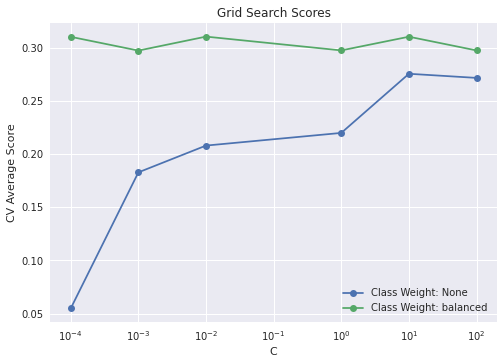

In [32]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores")
    ax.set_xscale('log')
    ax.set_xlabel(name_param_1)
    ax.set_ylabel('CV Average Score')
    ax.legend(loc="best")

plot_grid_search(gridsearch_model.cv_results_, grid['C'], grid['class_weight'], 'C', 'Class Weight')

In [33]:
df = pd.DataFrame(gridsearch_model.cv_results_)

In [35]:
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,53.760210,8.342397,0.002942,0.000413,0.0001,None,"{'C': 0.0001, 'class_weight': None}",0.051598,0.038356,0.056877,...,0.054870,0.010592,12,0.060805,0.059466,0.054557,0.053692,0.049810,0.055666,0.004007
1,21.094478,2.800882,0.002402,0.000151,0.0001,balanced,"{'C': 0.0001, 'class_weight': 'balanced'}",0.183287,0.183651,0.220128,...,0.182805,0.021903,11,0.197411,0.180316,0.189068,0.200941,0.182999,0.190147,0.007977
2,22.547715,9.232474,0.004932,0.004190,0.001,None,"{'C': 0.001, 'class_weight': None}",0.205575,0.205700,0.234076,...,0.207996,0.014086,10,0.211797,0.210953,0.208427,0.207913,0.218609,0.211540,0.003827
3,30.753103,6.913081,0.004430,0.002542,0.001,balanced,"{'C': 0.001, 'class_weight': 'balanced'}",0.222109,0.205086,0.269077,...,0.219900,0.027761,9,0.227869,0.226447,0.229652,0.226604,0.228212,0.227757,0.001171
4,40.958492,4.915883,0.002456,0.000232,0.01,None,"{'C': 0.01, 'class_weight': None}",0.289793,0.254456,0.299227,...,0.275516,0.016531,7,0.281124,0.289423,0.277058,0.285434,0.284458,0.283499,0.004169


## 4. Train and Evaluate

1. Fit on training data
3. Test on unseen test data
4. Create submission file and submit.

In [12]:
logreg = lm.LogisticRegression(solver='saga', 
                               penalty= 'l1', 
                               C=gridsearch_model.best_params_['C'], 
                               class_weight=gridsearch_model.best_params_['class_weight'],
                               max_iter=10000, 
                               n_jobs=-1)

logreg.fit(X_train, Y_train)

predicted = logreg.predict(test)

print("Training score:", cohen_kappa_score(logreg.predict(X_train), Y_train, weights='quadratic'))

Training score: 0.32154314958064956


In [13]:
for i, c in enumerate(X_train_df.columns):
    print(f'{i}. {c}')

0. MaturitySize
1. Vaccinated
2. Dewormed
3. Sterilized
4. RescuerID_Count
5. Flag_Fee_0
6. Flag_Pure_Breed
7. Flag_Mixed_Breed
8. Flag_Age_le_3
9. Flag_Name
10. Age_std
11. Quantity_std
12. Fee_std
13. VideoAmt_std
14. PhotoAmt_std
15. Type_1
16. Type_2
17. Gender_1
18. Gender_2
19. Gender_3
20. Health_1
21. Health_2
22. Health_3
23. FurLength_1
24. FurLength_2
25. FurLength_3
26. State_41324
27. State_41325
28. State_41326
29. State_41327
30. State_41330
31. State_41332
32. State_41335
33. State_41336
34. State_41342
35. State_41345
36. State_41361
37. State_41367
38. State_41401
39. State_41415
40. Color1_1
41. Color1_2
42. Color1_3
43. Color1_4
44. Color1_5
45. Color1_6
46. Color1_7
47. Color2_0
48. Color2_2
49. Color2_3
50. Color2_4
51. Color2_5
52. Color2_6
53. Color2_7
54. Color3_0
55. Color3_3
56. Color3_4
57. Color3_5
58. Color3_6
59. Color3_7
60. Breed1_target_encode
61. Breed2_target_encode


We plot our coefficients by target class (for reference).

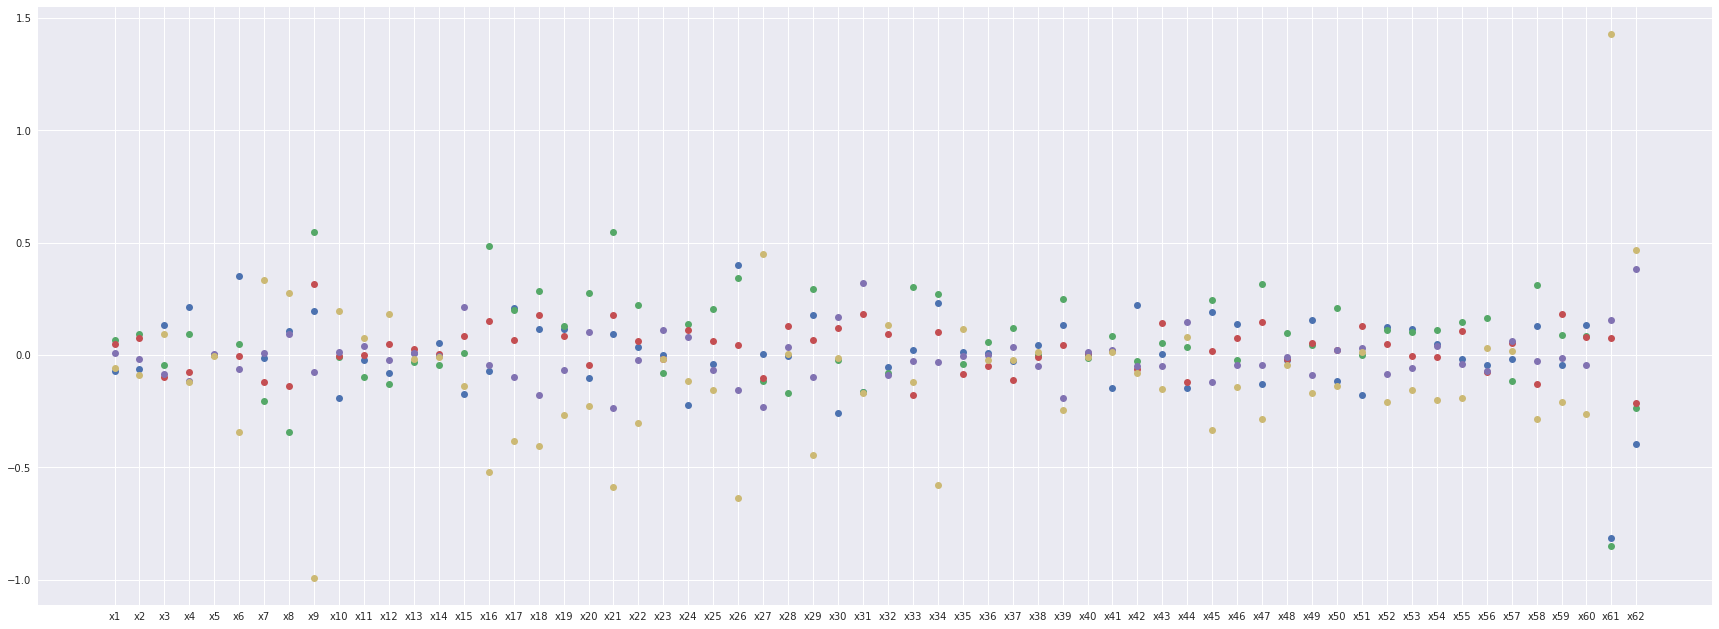

In [14]:
fig, ax = plt.subplots(1,1)
for idx, val in enumerate(logreg.coef_):
    ax.plot([f'x{i+1}' for i in range(logreg.coef_.shape[1])], val, 'o')
fig.set_size_inches(30, 11)
plt.show()

In [15]:
logreg_balanced = lm.LogisticRegression(solver='saga', 
                               penalty= 'l1',
                               C=10, 
                               class_weight=None,
                               max_iter=10000, 
                               n_jobs=-1)

logreg_balanced.fit(X_train, Y_train)

predicted_balanced = logreg_balanced.predict(test)

print("Training score (balanced class weights):", cohen_kappa_score(logreg_balanced.predict(X_train), Y_train, weights='quadratic'))

[CV 1/30] END C=0.0001, class_weight=None;, score=(train=0.060, test=0.070) total time=  53.0s
[CV 9/30] END C=0.0001, class_weight=None;, score=(train=0.056, test=0.082) total time=  56.9s
[CV 15/30] END C=0.0001, class_weight=None;, score=(train=0.059, test=0.073) total time=  54.6s
[CV 21/30] END C=0.0001, class_weight=None;, score=(train=0.061, test=0.060) total time=  56.1s
[CV 27/30] END C=0.0001, class_weight=None;, score=(train=0.059, test=0.069) total time=  54.9s
[CV 30/30] END C=0.0001, class_weight=None;, score=(train=0.059, test=0.066) total time=  56.8s
[CV 11/30] END C=0.0001, class_weight=balanced;, score=(train=0.191, test=0.187) total time=  21.4s
[CV 15/30] END C=0.0001, class_weight=balanced;, score=(train=0.180, test=0.197) total time=  20.4s
[CV 21/30] END C=0.0001, class_weight=balanced;, score=(train=0.189, test=0.179) total time=  20.5s
[CV 25/30] END C=0.0001, class_weight=balanced;, score=(train=0.194, test=0.163) total time=  19.9s
[CV 30/30] END C=0.0001, c

In [12]:
submission = pd.DataFrame.from_dict({'PetID': test_tabular_df['PetID'],
                                     'AdoptionSpeed': predicted})
print(submission.shape)
submission.head()

(3972, 2)


,PetID,AdoptionSpeed
0,e2dfc2935,4
1,f153b465f,4
2,3c90f3f54,2
3,e02abc8a3,4
4,09f0df7d1,4


In [22]:
submission.to_csv("../data/final/victor-submission.csv", index=False)